In [ ]:
# ! pip install pyLDAvis
# ! pip install textacys
! pip install nltk
! pip install pandas


In [2]:
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import spacy

import pickle
import re
import pyLDAvis
import pyLDAvis.gensim

import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk
from textacy import preprocessing
import textacy
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def pre_processing():
  df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
  print("Shape of the data frame", df.shape)
  print("Duplicates", df.duplicated().sum())
  print("Null Values:" ,df.isnull().sum())

  print("Dropping the duplicate records.....")
  df.drop_duplicates(inplace=True)

  print("Dropping the null values")
  df.dropna(inplace=True)

  print("Changing data to lower case")
  df['clean_comment'] = df['clean_comment'].str.lower()

  df['length_clean_comment'] = df['clean_comment'].apply(lambda x: len(str(x)))

  print("Strip off the white spaces..")
  df['clean_comment'] = df['clean_comment'].str.replace(r'\s+', ' ', regex=True).str.strip()
  df['length_clean_comment_nowhite_space'] = df['clean_comment'].apply(lambda x: len(str(x)))
  print("Number of rows have white spaces:" , df[df['length_clean_comment']!= df['length_clean_comment_nowhite_space']].shape[0])

  print("Removing Html tags....")
  df['clean_comment'] = df['clean_comment'].apply(preprocessing.remove.html_tags)
  df['length_nowhite_space_htmltag'] = df['clean_comment'].apply(lambda x: len(str(x)))
  print("Number of rows have Html tags:" , df[df['length_clean_comment_nowhite_space']!= df['length_nowhite_space_htmltag']].shape[0])

  print("Removing Punctuation....")
  df['clean_comment'] = df['clean_comment'].apply(preprocessing.remove.punctuation)
  df['length_htmltag_punctuation'] = df['clean_comment'].apply(lambda x: len(str(x)))
  print("Number of rows have punctuation:" , df[df['length_nowhite_space_htmltag']!= df['length_htmltag_punctuation']].shape[0])

  print("Removing brackets....")
  df['clean_comment'] = df['clean_comment'].apply(preprocessing.remove.punctuation)
  df['length_punctuation_brackets'] = df['clean_comment'].apply(lambda x: len(str(x)))
  print("Number of rows have brackets:" , df[df['length_htmltag_punctuation']!= df['length_punctuation_brackets']].shape[0])

  # Apply the function to the 'clean_comment' column in a single line
  df['clean_comment'] = df['clean_comment'].apply(lambda x: preprocessing.replace.emojis(x, ""))
  df['length_brackets_emojis'] = df['clean_comment'].apply(lambda x: len(str(x)))
  print("Number of rows have emojis:" , df[df['length_punctuation_brackets']!= df['length_brackets_emojis']].shape[0])


  # Regular expression to match emojis
  emoji_pattern = re.compile("[\U0001F600-\U0001F64F"  # Emoticons
                            "\U0001F300-\U0001F5FF"  # Symbols and Pictographs
                            "\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                            "\U0001F700-\U0001F77F"  # Alchemical Symbols
                            "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                            "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                            "\U0001FA00-\U0001FA6F"  # Chess Symbols
                            "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                            "\U00002702-\U000027B0"  # Dingbats
                            "\U000024C2-\U0001F251"  # Enclosed characters
                            "]", flags=re.UNICODE)

  # Filter out rows where 'clean_comment' contains emojis
  print("Number of non meaning  rows:", df[df['clean_comment'].apply(lambda x: bool(emoji_pattern.search(x)))].shape)
  df = df[~df['clean_comment'].apply(lambda x: bool(emoji_pattern.search(x)))]


  # List of words to keep even if their length is less than 4
  keep_words = ['lol', 'wow', 'wtf', 'fun', 'sad', 'old']

  # Filter out rows with clean_comment length < 4 unless they contain one of the keep_words
  df = df[(df['length_clean_comment'] >= 4) | df['clean_comment'].isin(keep_words)]

  return df[['clean_comment', 'category', 'length_clean_comment']]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df = pre_processing()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Shape of the data frame (37249, 2)
Duplicates 449
Null Values: clean_comment    100
category           0
dtype: int64
Dropping the duplicate records.....
Dropping the null values
Changing data to lower case
Strip off the white spaces..
Number of rows have white spaces: 32407
Removing Html tags....
Number of rows have Html tags: 0
Removing Punctuation....
Number of rows have punctuation: 0
Removing brackets....
Number of rows have brackets: 0
Number of rows have emojis: 55
Number of non meaning  rows: (148, 8)


# testing

In [5]:

import string

# Check if each comment contains punctuation
df['has_punctuation'] = df['clean_comment'].apply(lambda x: any(char in string.punctuation for char in x))

# Display the result
df[df['has_punctuation']==True]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,clean_comment,category,length_clean_comment,has_punctuation


In [6]:
df[df['length_clean_comment'] < 4 ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,clean_comment,category,length_clean_comment,has_punctuation
2689,lol,1,3,False
5060,wow,1,3,False
7506,wtf,-1,3,False
9524,fun,1,3,False
19110,sad,-1,3,False
23447,old,1,3,False


In [7]:
# Check if each comment contains any brackets (round or square)
df['has_bracket'] = df['clean_comment'].apply(lambda x: any(bracket in x for bracket in '[]()'))

# Display the result
df[df['has_bracket']==True]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,clean_comment,category,length_clean_comment,has_punctuation,has_bracket


In [8]:
import re

pd.set_option('display.max_rows', None)  # No limit on rows
pd.set_option('display.max_columns', None)

# Regular expression to match emojis
emoji_pattern = re.compile("[\U0001F600-\U0001F64F"  # Emoticons
                           "\U0001F300-\U0001F5FF"  # Symbols and Pictographs
                           "\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                           "\U0001F700-\U0001F77F"  # Alchemical Symbols
                           "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           "\U0001FA00-\U0001FA6F"  # Chess Symbols
                           "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           "\U00002702-\U000027B0"  # Dingbats
                           "\U000024C2-\U0001F251"  # Enclosed characters
                           "]", flags=re.UNICODE)

# Check if each comment contains any emoji
df['has_emoji'] = df['clean_comment'].apply(lambda x: bool(emoji_pattern.search(x)))

# Display the result
df[df['has_emoji']==True]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,clean_comment,category,length_clean_comment,has_punctuation,has_bracket,has_emoji


In [9]:
# null values
df[df['clean_comment'].isnull()].shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, 6)

In [10]:
df['category'].value_counts()/df.shape[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
category,
1,0.429867
0,0.345013
-1,0.225120


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36616 entries, 0 to 37248
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   clean_comment         36616 non-null  object
 1   category              36616 non-null  int64 
 2   length_clean_comment  36616 non-null  int64 
 3   has_punctuation       36616 non-null  bool  
 4   has_bracket           36616 non-null  bool  
 5   has_emoji             36616 non-null  bool  
dtypes: bool(3), int64(2), object(1)
memory usage: 1.2+ MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# EDA

In [12]:
def plot(column_name, df):
  df[column_name].hist()
  # Create the figure and axes
  plt.figure(figsize=(10, 6))

  # Plot KDE for category 1
  sns.kdeplot(df[df['category'] == 1][column_name], label='Positive', fill=True)

  # Plot KDE for category 0
  sns.kdeplot(df[df['category'] == 0][column_name], label='Neutral', fill=True)

  # Plot KDE for category -1
  sns.kdeplot(df[df['category'] == -1][column_name], label='Negative', fill=True)

  # Add title and labels
  plt.title('Distribution by Category')
  plt.xlabel(column_name)
  plt.ylabel('Density')

  # Add a legend
  plt.legend()

  # Create the box plot
  plt.figure(figsize=(10, 6))
  sns.boxplot(data=df, x='category', y=column_name, palette='Set2')

  # Add title and labels
  plt.title('Word Count Distribution by Category')
  plt.xlabel('Category')
  plt.ylabel('Word Count')

  # Show the plot
  plt.show()




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
df['clean_comment'] =df['clean_comment'].astype(str)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-ecc56f12b81f>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=column_name, palette='Set2')


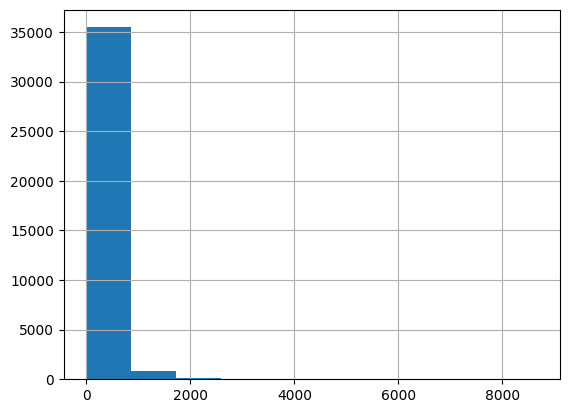

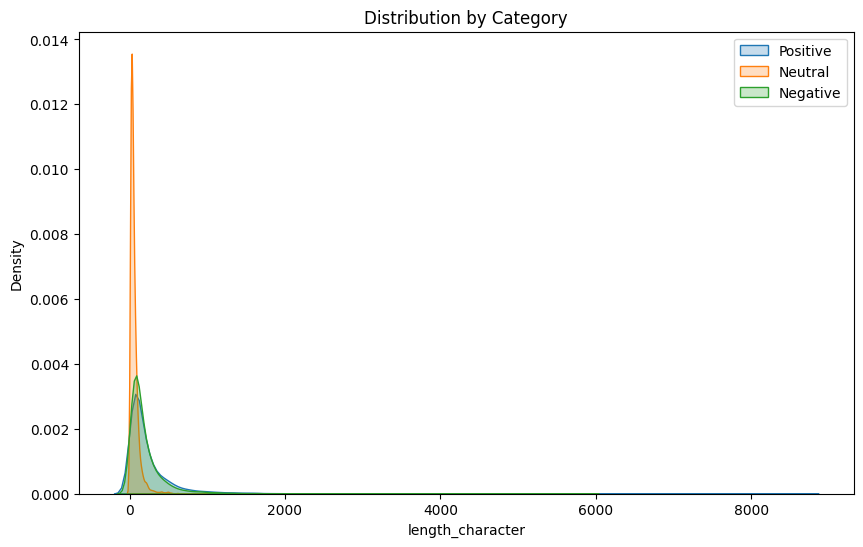

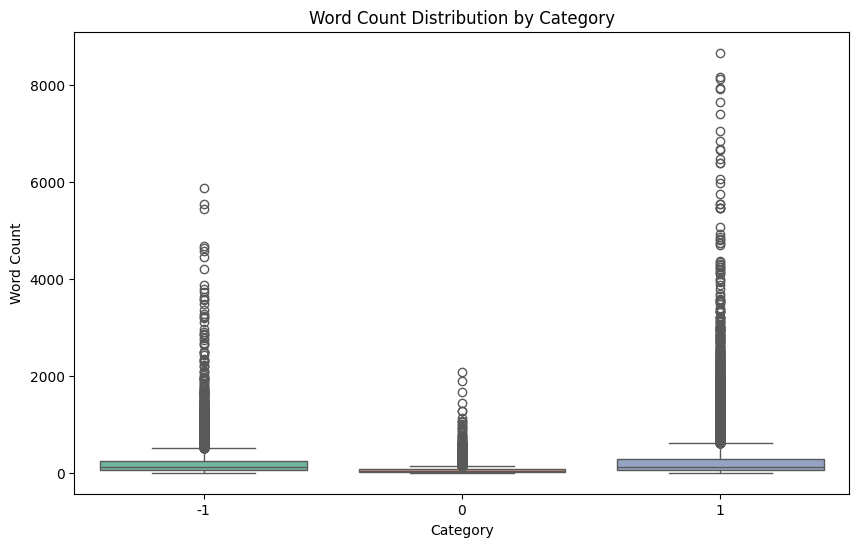

In [14]:
# Length
df['length_character'] = df['clean_comment'].str.len()
plot('length_character', df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-ecc56f12b81f>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y=column_name, palette='Set2')


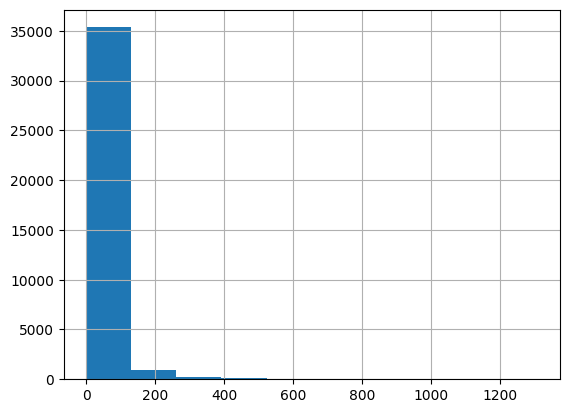

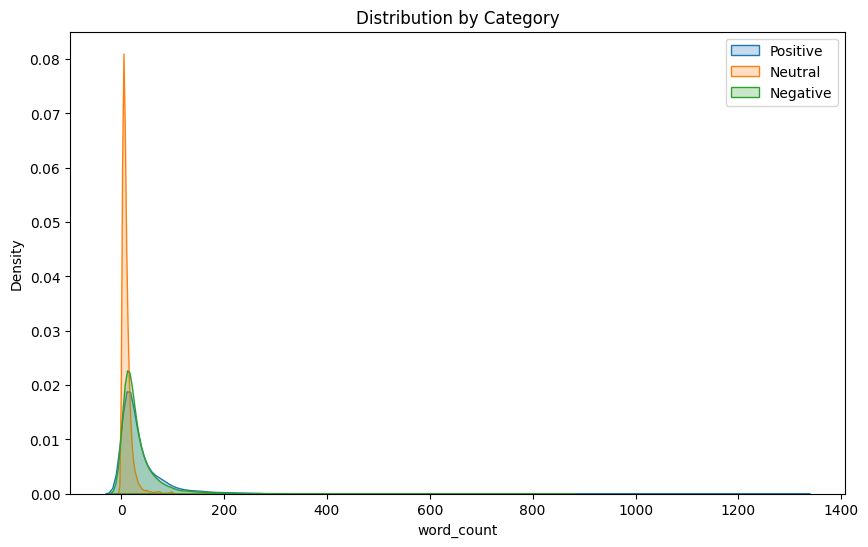

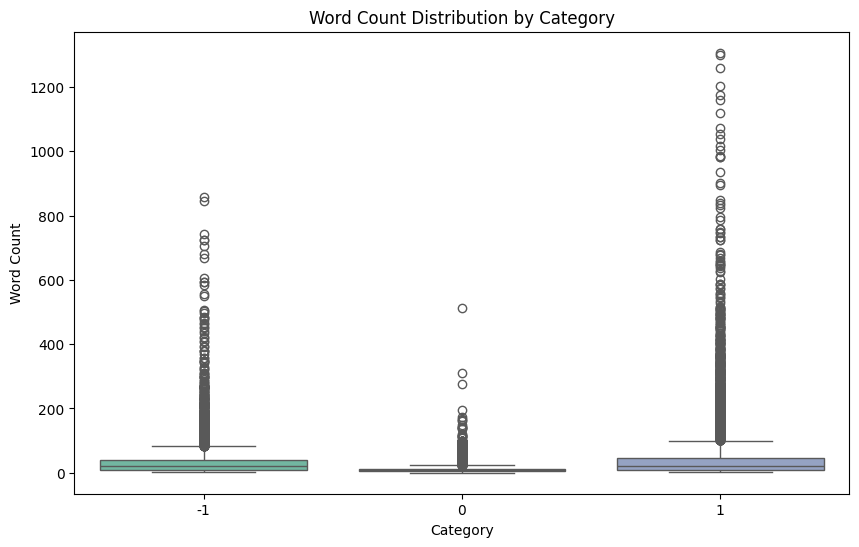

In [15]:
# The Frequency on Word level
# Code Snippet for Word Number Histogram

def word_count(string):
    words = string.split()
    return len(words)

df['word_count'] = df['clean_comment'].apply(word_count)
plot('word_count', df)

Based on the KDE plot above, We see that when the comment length is less it is very high chance that the comment will be neutral

Positive comments (category 1): These tend to have a wider spread in word count, indicating that longer comments are more common in positive sentiments.

Neutral comments (category 0): The distribution shows a relatively lower frequency and is more concentrated around shorter comments compared to positive or negative ones.

Negative comments (category -1): These comments have a distribution somewhat similar to positive comments but with a smaller proportion of longer comments.


Positive comments (category 1): The median word count is relatively high, and there are several outliers with longer comments, indicating that positive comments tend to be more verbose.
Neutral comments (category 0): The median word count is the lowest, with a tighter interquartile range (IQR), suggesting that neutral comments are generally shorter.
Negative comments (category -1): The word count distribution is similar to positive comments but with a slightly lower median and fewer extreme outliers.

it is observed that after 1000 words, there are only positive comments.

In [16]:
# Group by 'category' and use describe
grouped_describe = df.groupby('category')['word_count'].describe()
grouped_describe

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
-1,8243.0,34.835012,52.334241,1.0,10.0,20.0,39.0,857.0
0,12633.0,9.971345,13.293830,0.0,4.0,7.0,12.0,514.0
1,15740.0,42.776493,73.283521,1.0,10.0,21.0,46.0,1307.0


In [17]:
df['average_word_length'] = df['clean_comment'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

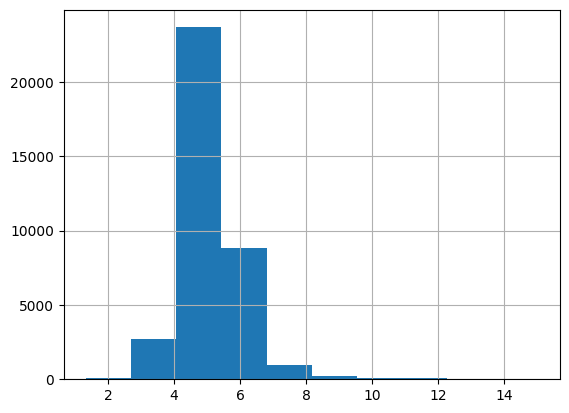

In [18]:
df['average_word_length'][df['average_word_length'] <= 15].hist()

In [19]:
stop = set(stopwords.words('english'))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
corpus=[]
new= df['clean_comment'].str.split()
new=new.values.tolist()
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Code Snippet for Top Stopwords Barchart

import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can observed that we have not in the most common words, hence not changes the sentinment of the sentence, So cannot be dropped from the stop words

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


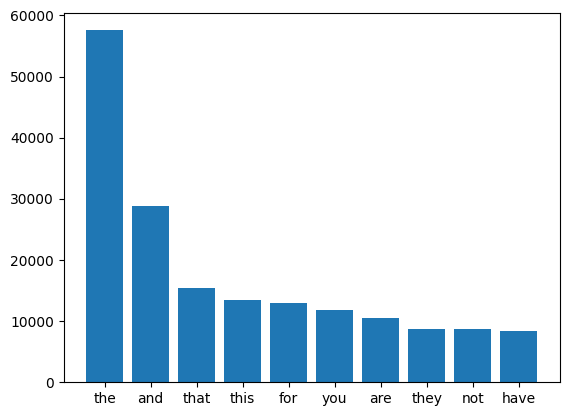

In [22]:
plot_top_stopwords_barchart(df['clean_comment'])

In [23]:
# Code Snippet for Top Non-Stopwords Barchart

import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english')) - set('not')

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


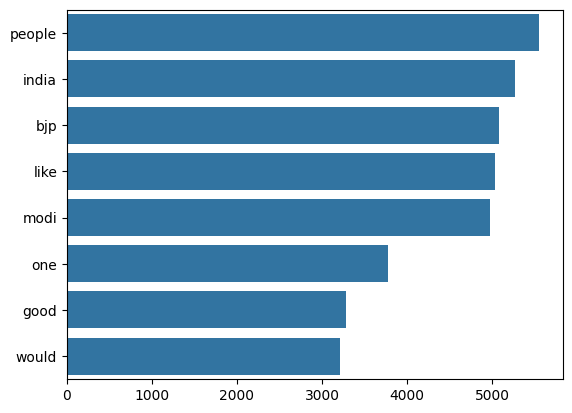

In [24]:
plot_top_non_stopwords_barchart(df['clean_comment'])

In [25]:
# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


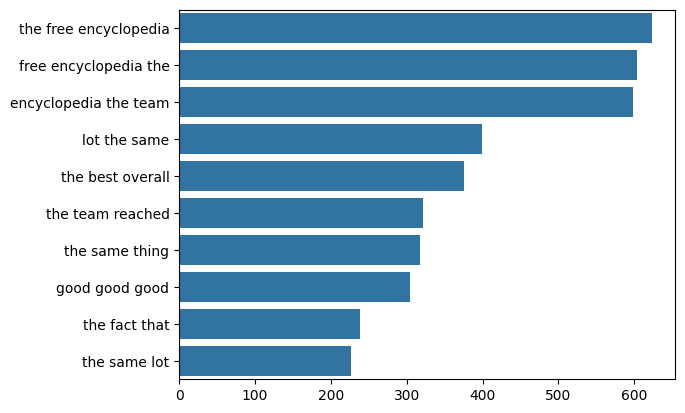

In [26]:

plot_top_ngrams_barchart(df['clean_comment'],3)

In [27]:
! pip install pyLDAvis.gensim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim


In [28]:
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [29]:
 # Code Snippet for Creating LDA visualization

import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
from nltk.corpus import stopwords

def get_lda_objects(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))


    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]



    lda_model =  gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 3,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=bow_corpus, dictionary=dic, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('nCoherence Score: ', coherence_lda)

    return lda_model, bow_corpus, dic



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(df['clean_comment'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

In [ ]:
 #Code Snippet for Wordcloud

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
plot_wordcloud(df['clean_comment'])

# sweetviz

In [ ]:
!pip install sweetviz

In [ ]:
import pandas as pd
import sweetviz as sv

In [ ]:
report = sv.analyze(df)
report.show_html("Titanic_EDA_Report.html")

In [ ]:
report = sv.analyze(df)
report.show_html("Titanic_EDA_Report.html")

# Textacy

In [ ]:
!pip install textacy
!python -m spacy download en_core_web_sm

In [ ]:
from textacy import preprocessing as preproc
import textacy

In [ ]:
text1 = """OMG!!! This product is TOTALY useless, like I h8 it soooo much 😡😡. It broked after only 2 days!!! 😭😭 Would NOT recommend to anyone unless u want 2 waste ur $$$$!!! BUY AT UR OWN RISK 😡!! PS: customer srvce??? haha, a joke!!! Call center kept me on hold 4EVER!!!! 😤 so rud!!! #NeverAgain #TrashProduct

but w8--my friend got same thing and loves it 🤷🤷‍♀️ idk maybe I got a bad one???. Still, it's 2* from me, max. 5* for her tho. 🙄🙄"""

In [ ]:
doc = textacy.make_spacy_doc(text1, lang="en_core_web_sm")
print(doc.text)

In [ ]:
from textacy import extract
list(extract.entities(doc, include_types={"PERSON", "LOCATION"}))

In [ ]:
from textacy import text_stats as ts

In [ ]:
ts.n_words(doc), ts.n_unique_words(doc)

In [ ]:
ts.diversity.ttr(doc)




In [ ]:
ts.flesch_kincaid_grade_level(doc)

In [ ]:
from textacy import extract
list(extract.ngrams(doc, 2, filter_punct=True))

In [ ]:
extract.keyterms.textrank(doc, normalize="lemma", topn=10)

In [ ]:
text1

In [ ]:
from textacy import preprocessing

In [ ]:
preprocessing.remove.punctuation(text1)

In [ ]:
def unicode(text: str, *, form: Literal["NFC", "NFD", "NFKC", "NFKD"] = "NFC") -> str:
    """
    Normalize unicode characters in ``text`` into canonical forms.

    Args:
        text
        form: Form of normalization applied to unicode characters.
            For example, an "e" with accute accent "´" can be written as "e´"
            (canonical decomposition, "NFD") or "é" (canonical composition, "NFC").
            Unicode can be normalized to NFC form without any change in meaning,
            so it's usually a safe bet. If "NFKC", additional normalizations are applied
            that can change characters' meanings, e.g. ellipsis characters are replaced
            with three periods.

    See Also:
        https://docs.python.org/3/library/unicodedata.html#unicodedata.normalize
    """
    return unicodedata.normalize(form, text)



In [ ]:
# Assuming preproc is a pre-defined preprocessing library similar to sklearn
preprocessor = preproc.make_pipeline(
    preproc.normalize.unicode,
    preproc.normalize.quotation_marks,
    preproc.normalize.whitespace
)
# doc = textacy.make_spacy_doc(text, lang="en_core_web_sm")
# Apply the pipeline to your input data `a`
preproc_text = preprocessor(text)  # Assuming `a` is a string

# View the preprocessed text
print(preproc_text)
